# Setup

## Task

Suppose we have hidden variable states $x_0, x_1, x_2, \dots \in \mathbb R^n$ which evolve over time according to a linear dynamics rule $x_t = Ax_{t-1} + w_{t-1}$, where $A \in \mathbb R^{n\times n}$ is the matrix determining the dynamics and $w_t \sim \mathcal N(0^n, \Sigma_\text{process}^{n\times n})$ is IID process noise.

At each time $t$, we then make an observation $y_t \in \mathbb R^m$ which is determined by $x_t$ according to $y_t = Ox_t + v_t$ for some observation matrix $O \in \mathbb R^{m\times n}$ and some IID observation noise $v_t \sim \mathcal N(0^m, \Sigma_\text{obs}^{m\times m})$. For simplicity, we shall take $m=n$ and $O$ to be the identity matrix.

In other words, we have a hidden Markov process where both the state transitions and observations are linear, with Gaussian noise.

The task we would like to accomplish is to take in a series of observations $y_0, \dots, y_T$ as an input and use them to calculate an output $\hat x_0, \dots, \hat x_T$, minimizing the squared error $\mathcal L = \sum_{t=0}^T \|x_t - \hat x_t\|_2^2$.

## Theory

The optimal estimator for this task (in the sense of minimizing mean squared error) is known as the Kalman filter and leverages Bayesian inference to combine a prior guess $P(x_t \mid y_1,\dots, y_{t-1})$ with a likelihood $P(y_t \mid x_t)$ to obtain a posterior guess $P(x_t \mid y_1,\dots,y_t)$. The result is that the mean of the posterior distribution will be a linear combination of the guess resulting from the mean of the prior distribution and our new observation:

$$\hat x_t = A\hat x_{t-1} + K_t(y_t - OA\hat x_{t-1}),$$

where $K_t \in \mathbb R^{n\times m}$ is known as the Kalman gain matrix and represents how much we trust our new observation compared to how much we trust our previous guess.

The Kalman gain has its own evolution equation (which depends on the system parameters $A,\Sigma_\text{process},O,\Sigma_\text{obs}$, but not on $x_t$, $y_t$, or $\hat x_t$), but the steady-state value of the Kalman gain $K_\infty$ (which $K_t$ converges to under some reasonable assumptions) is given by the equation

$$K_\infty = \Sigma_\infty O^T (\Sigma_\text{obs} + O\Sigma_\infty O^T)^{-1},$$

where $\Sigma_\infty \in \mathbb R^{n\times n}$ is the steady-state covariance of the estimated latent state and can be calculated by solving the discrete Riccati equation

$$\Sigma_\infty = A(\Sigma_\infty - \Sigma_\infty O^T(O\Sigma_\infty O^T + \Sigma_\text{obs})^{-1}O\Sigma_\infty)A^T + \Sigma_\text{process}.$$

Since we are taking $O$ to be the identity, we can simplify this to obtain

$$K_\infty = \Sigma_\infty (\Sigma_\text{obs} + \Sigma_\infty)^{-1},$$

and

$$\Sigma_\infty = A(\Sigma_\infty - \Sigma_\infty(\Sigma_\infty + \Sigma_\text{obs})^{-1}\Sigma_\infty)A^T + \Sigma_\text{process}.$$

For more information, see [this tutorial](https://compneuro.neuromatch.io/tutorials/W3D2_HiddenDynamics/student/W3D2_Tutorial3.html) introducing the Kalman filter and [these lecture slides](https://www.cs.cmu.edu/~motionplanning/papers/sbp_papers/kalman/kleeman_understanding_kalman.pdf).

## Model

Drawing inspiration from a neural net, we would like to compute the optimal output to the task using a set of $\ell$ neurons with internal states of $r = (r_1, \dots, r_\ell)$, whose dynamics are governed by the equation $r_t = Mr_{t-1} + Ky_t$ (here, $K$ is analogous to but not the same as the Kalman gain above), where $M \in \mathbb R^{\ell\times\ell}$ and $K \in \mathbb R^{\ell\times m}$. That is, the internal states of the neurons will update according to both the state of the network at the previous time step as well as the new information. Then, our prediction will be a linear function of the neural states: $\hat x_t = Wr_t$, where $W \in \mathbb R^{n\times\ell}$.

# Exploration 1

What if we start small (let $\ell = m = n = 3$ so that we are tracking three variables with three neurons) and attempt to train the neural net to learn the Kalman filter? What does the loss look like over time for various initial values of $M$? What if we change the support of $M$?

In [1]:
# Import everything needed
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
import tqdm

In [2]:
# Define some arbitrary parameters
n = 3
m = 3
A = np.diag([0.98, 0.96, 0.85])
x0 = np.array([100, 100, 100])
sigma_process = 10
Sigma_process = (sigma_process**2)*np.eye(3)
O = np.eye(3)
sigma_obs = 25
Sigma_obs = (sigma_obs**2)*np.eye(3)
rng = np.random.default_rng()
num_steps = 100

assert A.shape == (n,n)
assert x0.shape == (n,)
assert Sigma_process.shape == (n,n)
assert O.shape == (m,n)
assert Sigma_obs.shape == (m,m)

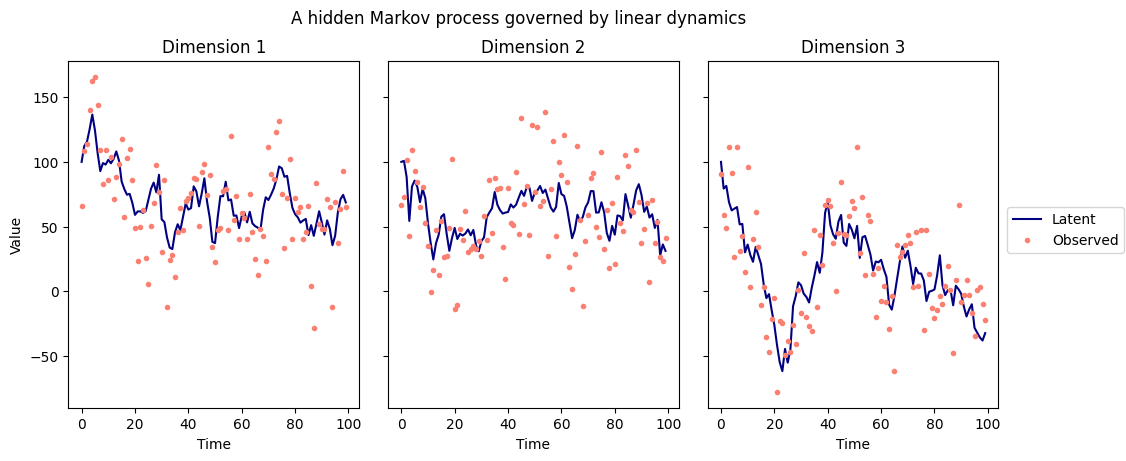

In [3]:
# First, let's simulate the hidden Markov process.
def simulate_hm_process(rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps):
    """Simulate a hidden Markov process governed by linear dynamics.

    Arguments:
    rng: numpy.random.Generator; the RNG used for generating random Gaussian noise
    n: int; the dimensionality of the latent state
    m: int; the dimensionality of the observations
    A: np.ndarray, shape (n, n); the transition matrix for the latent state
    x0: np.ndarray, shape (n,); the initial latent state
    Sigma_process: np.ndarray, shape (n, n); the covariance of the process noise
    O: np.ndarray, shape (m, n); the observation matrix
    Sigma_obs: np.ndarray, shape (m, m); the covariance of the observation noise
    num_steps: int, the number of steps to simulate for

    Returns:
    ts: np.ndarray, shape (num_steps); the time values of the process
    xs: np.ndarray, shape (num_steps, n); the simulated latent states
    ys: np.ndarray, shape (num_steps, m); the simulated observations
    """
    xs = np.zeros((num_steps, n))
    ys = np.zeros((num_steps, m))
    curr = x0
    for i in range(num_steps):
        xs[i] = curr
        ys[i] = O@curr + rng.multivariate_normal(np.zeros(m), Sigma_obs)
        curr = A@curr + rng.multivariate_normal(np.zeros(n), Sigma_process)
    return np.arange(num_steps), xs, ys


# Let's simulate it with some arbitrary parameters.
ts, xs, ys = simulate_hm_process(rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)


# Now, let's plot it!
def plot_hm_process(title, ts, xs, ys, xhats=None):
    """Plot a hidden Markov process, optionally with an inferred latent state.

    Arguments:
    title: str; the title of the plot
    ts: ndarray, shape (num_steps); the time values of the process
    xs: ndarray, shape (num_steps, n); the latent states
    ys: ndarray, shape (num_steps, m); the observations
    xhats: ndarray, shape (num_steps, n); the inferred latent states (optional)

    Returns:
    Nothing.

    Raises:
    ValueError; m != n (this function assumes the observation matrix is the identity).
    """
    if xs.shape[1] != ys.shape[1]:
        raise ValueError('Observation matrix is not the identity')
    fig, axs = plt.subplots(1, 3, sharey=True)
    fig.set_size_inches(12, 4.5)
    for i in range(3):
        axs[i].plot(ts, xs[:,i], '-', color='navy', label='Latent')
        axs[i].plot(ts, ys[:,i], '.', color='salmon', label='Observed')
        if xhats is not None:
            axs[i].plot(ts, xhats[:,i], '-', color='dodgerblue', label='Inferred')
        axs[i].set_title(f'Dimension {i+1}')
        axs[i].set_xlabel('Time')
    axs[0].set_ylabel('Value')
    fig.legend(*axs[0].get_legend_handles_labels(), loc='right', borderaxespad=0.15)
    fig.subplots_adjust(wspace=0.1)
    fig.suptitle(title, y=0.995)
    plt.show()

plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)

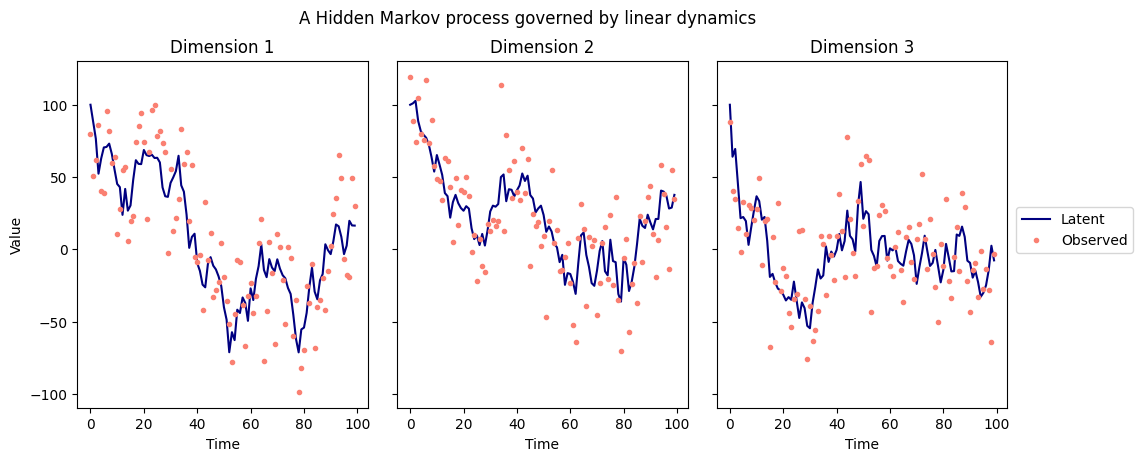

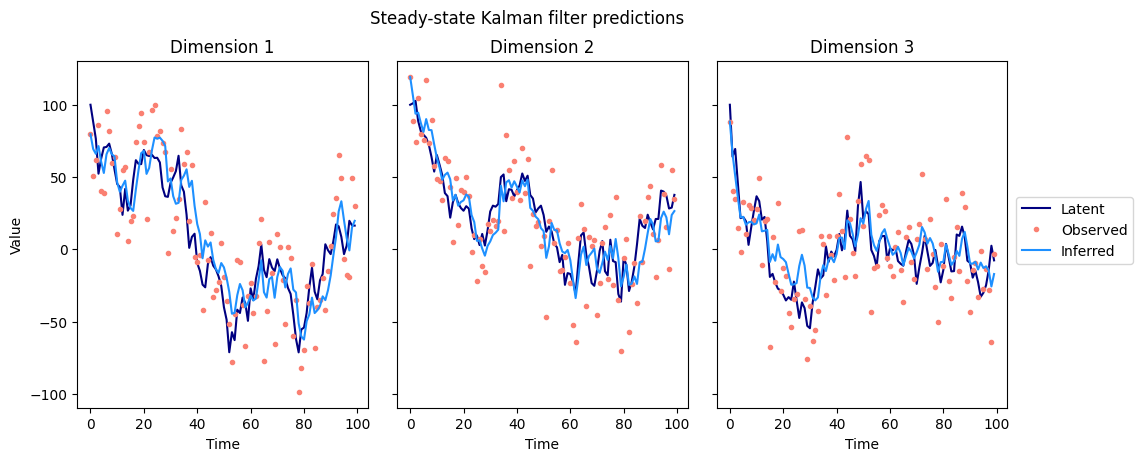

In [4]:
# Now, what if we try to predict what the latent states were based
# on the observations by using a steady-state Kalman filter, assuming
# we know the true values of A, Sigma_process, O, and Sigma_obs?


# First, we have to solve the Riccati equation to obtain Sigma_infty
# and K_infty.
def riccati_error(Sigma_infty, n, A, Sigma_process, O, Sigma_obs):
    """Given a candidate value for Sigma_infty, calculate the squared
    Frobenius distance between the two sides of the Riccati equation.

    Arguments:
    Sigma_infty: np.ndarray, shape (n**2,); the candidate value, flattened
    n: int; the dimensionality of the latent state
    A: np.ndarray, shape (n, n); the transition matrix for the latent state
    Sigma_process: np.ndarray, shape (n, n); the covariance of the process noise
    O: np.ndarray, shape (m, n); the observation matrix
    Sigma_obs: np.ndarray, shape (m, m); the covariance of the observation noise
    
    Returns:
    d: float, the squared Frobenius distance
    """
    Sigma_infty = np.reshape(Sigma_infty, (n,n))
    return np.linalg.norm(Sigma_infty -
        (A @ (Sigma_infty - Sigma_infty @ O.T @ np.linalg.inv(
            O @ Sigma_infty @ O.T + Sigma_obs) @ O @ Sigma_infty) @ A.T
        + Sigma_process), ord='fro')**2


def find_steady_state_kalman_parameters(n, A, Sigma_process, O, Sigma_obs):
    """Calculate the steady-state Kalman filter parameters.

    Arguments:
    n: int; the dimensionality of the latent state
    A: np.ndarray, shape (n, n); the transition matrix for the latent state
    Sigma_process: np.ndarray, shape (n, n); the covariance of the process noise
    O: np.ndarray, shape (m, n); the observation matrix
    Sigma_obs: np.ndarray, shape (m, m); the covariance of the observation noise

    Returns:
    Sigma_infty: np.ndarray, shape (n, n); the steady-state prediction covariance
    K_infty: np.ndarray, shape (n, m); the steady-state Kalman gain

    Raises:
    sklearn.exceptions.ConvergenceWarning; the Riccati equation solver does not
    converge
    """
    res = scipy.optimize.minimize(riccati_error, np.eye(n).flatten(), args=(n, A, Sigma_process, O, Sigma_obs))
    if not res.success:
        raise sklearn.exceptions.ConvergenceWarning
    Sigma_infty = np.reshape(res.x, (n,n))
    K_infty = Sigma_infty @ np.linalg.inv(Sigma_obs + Sigma_infty)
    return Sigma_infty, K_infty


# Now, we can use the steady-state Kalman filter to infer x-hat values.
def steady_state_kalman_infer(n, A, Sigma_process, O, Sigma_obs, ys):
    """Infer hidden Markov latent states using a steady-state Kalman filter.

    Arguments:
    n: int; the dimensionality of the latent state
    A: np.ndarray, shape (n, n); the transition matrix for the latent state
    Sigma_process: np.ndarray, shape (n, n); the covariance of the process noise
    O: np.ndarray, shape (m, n); the observation matrix
    Sigma_obs: np.ndarray, shape (m, m); the covariance of the observation noise
    ys: np.ndarray, shape (num_steps, m); the observations

    Returns:
    xhats: np.ndarray, shape (num_steps, n); the inferred latent states
    Sigma_infty: np.ndarray, shape (n, n); the steady-state prediction covariance
    K_infty: np.ndarray, shape (n, m); the steady-state Kalman gain

    Raises:
    sklearn.exceptions.ConvergenceWarning; the Riccati equation solver does not
    converge
    """
    Sigma_infty, K_infty = find_steady_state_kalman_parameters(n, A, Sigma_process, O, Sigma_obs)
    num_steps = ys.shape[0]
    xhats = np.zeros((num_steps, n))
    curr = np.linalg.solve(O, ys[0])
    xhats[0] = curr
    for i in range(1,num_steps):
        curr = A@curr + K_infty@(ys[i] - O@A@curr)
        xhats[i] = curr
    return xhats, Sigma_infty, K_infty

ts, xs, ys = simulate_hm_process(rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)
xhats, _, _ = steady_state_kalman_infer(n, A, Sigma_process, O, Sigma_obs, ys)


# Now, let's plot it!
plot_hm_process('A Hidden Markov process governed by linear dynamics', ts, xs, ys)
plot_hm_process('Steady-state Kalman filter predictions', ts, xs, ys, xhats)

In [5]:
# Now, let's see if we can train a linear dynamical system to learn the Kalman filter.
class NeuralNet:
    def __init__(self, M0, K0, W0, r0):
        self.M = M0
        self.K = K0
        self.W = W0
        self.r0 = r0
        self.num_neurons = self.r0.shape[0]
        self.latent_dim = self.W.shape[0]
        self.obs_dim = self.K.shape[1]

    def forward(self, ys):
        num_steps = ys.shape[0]
        rs = np.zeros((num_steps, self.r0.shape[0]))
        xhats = np.zeros((num_steps, self.W.shape[0]))
        
        r = self.r0
        for i in range(num_steps):
            r = self.M @ r + self.K @ ys[i]
            rs[i] = r
            xhats[i] = self.W @ r

        return rs, xhats

    @staticmethod
    def calc_loss(xhats, xs):
        return np.sum((xhats-xs)**2)/2

    def backward(self, ys, xs, eta):
        num_steps = ys.shape[0]        
        rs, xhats = self.forward(ys)

        # dr_dr[m,n,k,l] represents dr^m_k / dr^n_l for m > n and otherwise 0
        dr_dr = np.zeros((num_steps, num_steps, self.num_neurons, self.num_neurons))
        for m in range(num_steps-1, -1, -1):
            for k in range(self.num_neurons):
                for l in range(self.num_neurons):
                    dr_dr[m,m-1,k,l] = self.M[k,l]
            for n in range(m-2, -1, -1):
                for k in range(self.num_neurons):
                    for l in range(self.num_neurons):
                        dr_dr[m,n,k,l] = sum(dr_dr[m,n+1,k,i]*self.M[i,l] for i in range(self.num_neurons))

        # dL_dr[n,k] represents dL / dr^n_k where L = 1/2 sum_{im} (xhat^m_i - x^m_i)^2
        dL_dr = np.zeros((num_steps, self.num_neurons))
        for n in range(num_steps):
            for k in range(self.num_neurons):
                dL_dr[n,k] = sum((self.W[i,k]*rs[n,k]-xs[n,i])*self.W[i,k] for i in range(self.latent_dim)) + sum(sum(sum(
                    (self.W[i,j]*rs[m,j]-xs[m,i])*self.W[i,j]*dr_dr[m,n,j,k]
                    for i in range(self.latent_dim))
                    for j in range(self.num_neurons))
                    for m in range(n+1,num_steps))
        
        # dr_dM[n,k,i,l] represents dr^n_k / dM_il
        dr_dM = np.zeros((num_steps, self.num_neurons, self.num_neurons, self.num_neurons))
        for n in range(num_steps):
            for k in range(self.num_neurons):
                for i in range(self.num_neurons):
                    for l in range(self.num_neurons):
                        dr_dM[n,k,i,l] = rs[n-1,l] if i==k else 0

        # dr_dK[n,k,i,l] represents dr^n_k / dK_il
        dr_dK = np.zeros((num_steps, self.num_neurons, self.num_neurons, self.obs_dim))
        for n in range(num_steps):
            for k in range(self.num_neurons):
                for i in range(self.num_neurons):
                    for l in range(self.obs_dim):
                        dr_dK[n,k,i,l] = ys[n,l] if i==k else 0

        # dL_dM[i,j] represents dL / dM_ij
        dL_dM = np.zeros((self.num_neurons, self.num_neurons))
        for i in range(self.num_neurons):
            for j in range(self.num_neurons):
                dL_dM[i,j] = sum(sum(dL_dr[n,k]*dr_dM[n,k,i,j] for n in range(num_steps)) for k in range(self.num_neurons))

        # dL_dK[i,j] represents dL / dK_ij
        dL_dK = np.zeros((self.num_neurons, self.obs_dim))
        for i in range(self.num_neurons):
            for j in range(self.obs_dim):
                dL_dK[i,j] = sum(sum(dL_dr[n,k]*dr_dK[n,k,i,j] for n in range(num_steps)) for k in range(self.num_neurons))

        L = NeuralNet.calc_loss(xhats, xs)
        return L, dL_dM, dL_dK

    def train_epoch(self, eta, num_trials, rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps):
        losses = np.zeros(num_trials)
        dL_dMs = np.zeros((num_trials, self.num_neurons, self.num_neurons))
        dL_dKs = np.zeros((num_trials, self.num_neurons, self.obs_dim))
        
        for i in tqdm.tqdm(range(num_trials)):
            _, xs, ys = simulate_hm_process(rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)
            L, dL_dM, dL_dK = self.backward(ys, xs, eta)
            losses[i] = L
            dL_dMs[i] = dL_dM
            dL_dKs[i] = dL_dK

        dL_dM_mean = np.mean(dL_dMs, axis=0)
        dL_dK_mean = np.mean(dL_dKs, axis=0)
        for i in range(self.num_neurons):
            for j in range(self.num_neurons):
                self.M[i,j] -= eta * dL_dM_mean[i,j]
        for i in range(self.num_neurons):
            for j in range(self.obs_dim):
                self.K[i,j] -= eta * dL_dK_mean[i,j]

        return losses, dL_dMs, dL_dKs

    def train(self, etas, num_trials_per, rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps):
        for eta in etas:
            Ls, _, _ = self.train_epoch(eta, num_trials_per, rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)
            print('Average loss', np.mean(Ls))


[[ 0.17346832  0.74116818 -0.34305452]
 [ 0.22966587  1.00568568 -1.57669632]
 [-0.76429319  0.94477687 -0.279154  ]]


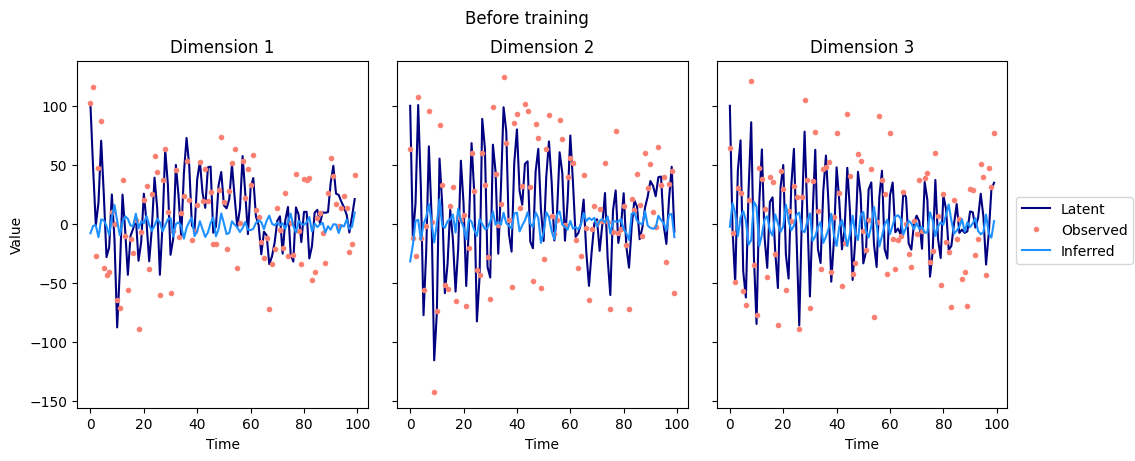

Loss 229740.57787473727


100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.45it/s]


Average loss 348415.02391178143


100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.35it/s]


Average loss 210949.78032600973


100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.28it/s]


Average loss 148500.3795094077


100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.20it/s]


Average loss 127964.64465947062


100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.28it/s]


Average loss 92320.26991798774


100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.23it/s]


Average loss 77921.26956020566


100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.19it/s]


Average loss 72618.47603416993


100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.13it/s]


Average loss 72274.79388761694


100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.14it/s]


Average loss 64581.886781446054


100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.15it/s]


Average loss 61016.310770694145


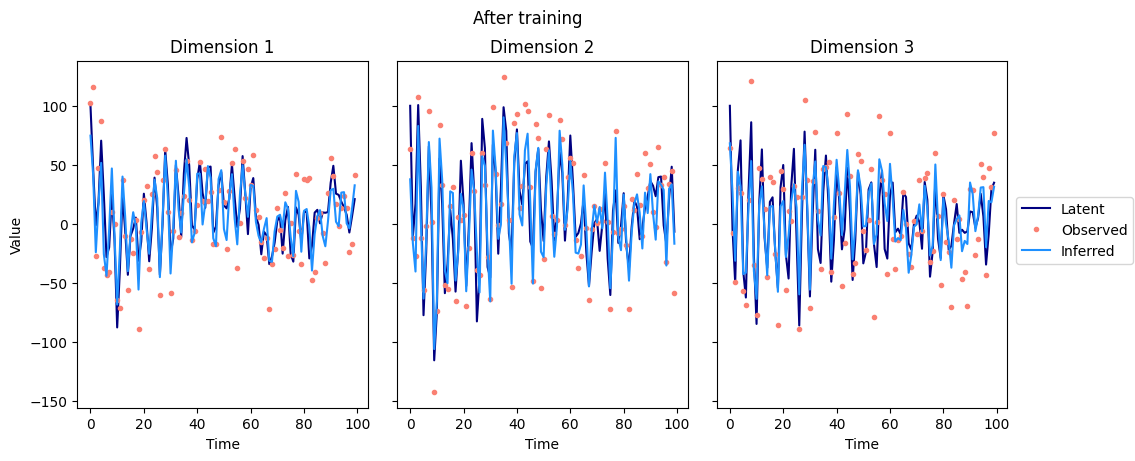

Loss 47251.28242664753
M = [[ 0.01728547  0.27401854 -0.01586257]
 [-0.24610277 -0.01615671  0.00402032]
 [-0.00952938 -0.00982146  0.05529222]]
K = [[0.28455456 0.07409098 0.20811341]
 [0.09808811 0.60486547 0.23377788]
 [0.25079095 0.19525868 0.4139288 ]]


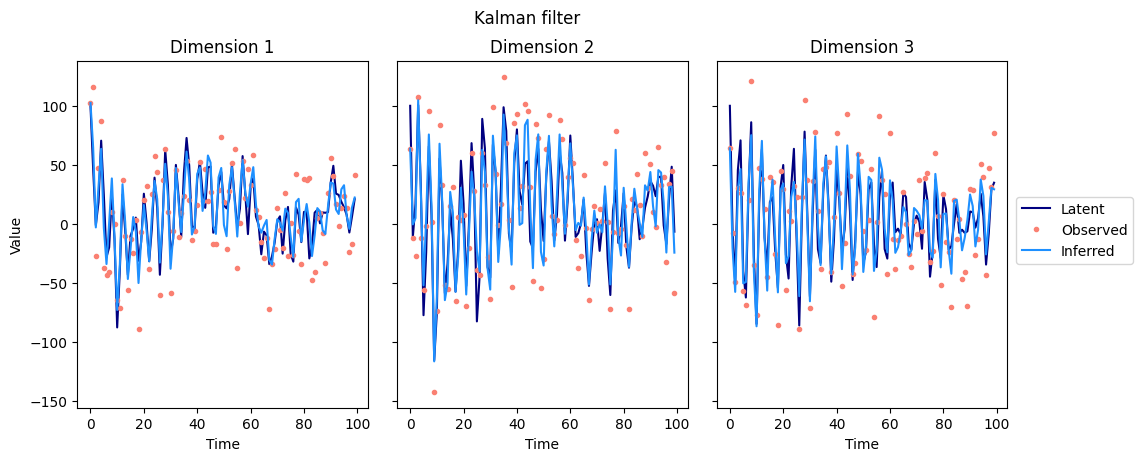

Loss 29430.090441219276
M = [[ 0.16725038  0.34831242 -0.04024753]
 [ 0.18221666  0.32720347 -0.74466353]
 [-0.55896198  0.46637815  0.01391403]]
K = [[0.25566578 0.1211457  0.08629543]
 [0.1211457  0.48183642 0.11020262]
 [0.08629543 0.11020262 0.32135641]]


In [6]:
# What happens when we train the neural net on this task?
def mk_rand_matrix(rng):
    return rng.multivariate_normal(np.zeros(3),np.eye(3),(3,))

def mk_rand_matrix_envals(rng):
    # D = np.diag((0.9, 0.88, 0.85))
    D = np.array([[0,0.95,0],[-0.95,0,0],[0,0,0.9]])
    P = mk_rand_matrix(rng)
    return P @ D @ np.linalg.inv(P)

A = mk_rand_matrix_envals(rng)
print(A)

nn = NeuralNet(0.1*mk_rand_matrix(rng), 0.1*mk_rand_matrix(rng), np.eye(3), x0)
ts, xs, ys = simulate_hm_process(rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)
_, xhats = nn.forward(ys)
plot_hm_process('Before training', ts, xs, ys, xhats)
print('Loss', NeuralNet.calc_loss(xhats, xs))
nn.train([5e-7, 5e-7, 5e-7, 5e-7, 5e-7, 5e-7, 5e-7, 5e-7, 5e-7, 5e-7], 40, rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)
_, xhats = nn.forward(ys)
plot_hm_process('After training', ts, xs, ys, xhats)
print('Loss', NeuralNet.calc_loss(xhats, xs))
print('M =', nn.M)
print('K =', nn.K)

# How does it compare to a Kalman filter?
xhats, _, K_infty = steady_state_kalman_infer(n, A, Sigma_process, O, Sigma_obs, ys)
plot_hm_process('Kalman filter', ts, xs, ys, xhats)
print('Loss', NeuralNet.calc_loss(xhats, xs))
print('M =', A - K_infty@O@A)
print('K =', K_infty)
